### Datasets

We will perform the processing of ecoli dataset, available for download here: http://archive.ics.uci.edu/ml/datasets/ecoli.

Ecoli is a real-life dataset containting information about protein localization sites. The dataset contains 336 rows with 8 attributes. This is a multi-class problem.

In [28]:
import os
import numpy as np

seed = 0
np.random.seed(seed)

%matplotlib inline

dataset_name = 'new_ecoli'
dir=os.getcwd() # te sciezkie potem poprawie, jak bedzie po releasie i w innym miejscu notebook

### Data loading

We begin with loading the data - it can be performed using the library's util for loading arff type files. The util loads arff files and performs onehotencoding for discrete variables.
The features will be ordered with all the continuous features first, followed by the ones modified by one hot encoder. It will also say how many continuous features there is for further normalization.

In [29]:
from multi_imbalance.utils.data import preprocess_dataset
X,y, con_len = preprocess_dataset(f'{dir}/../data/arff/{dataset_name}.arff', return_cat_length=True)
print(X[:5])
print(y[:5])

[[ 1.51793 12.79     3.5      1.12    73.03     0.64     8.77     0.
   0.     ]
 [ 1.51643 12.16     3.52     1.35    72.89     0.57     8.53     0.
   0.     ]
 [ 1.51793 13.21     3.48     1.41    72.64     0.59     8.43     0.
   0.     ]
 [ 1.51299 14.4      1.74     1.54    74.55     0.       7.59     0.
   0.     ]
 [ 1.53393 12.3      0.       1.      70.16     0.12    16.19     0.
   0.24   ]]
[0 5 0 4 1]


This dataset is characterized by multi-class imbalance. To visualize, a dimension reduction technique needs to be applied, as this dataset has multiple dimensions. Here, for dimension recution, we use PCA.

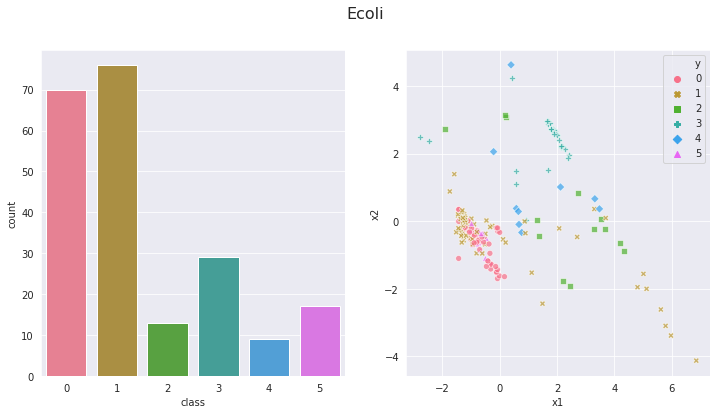

In [30]:
# To sie raczej ukryje w jakieś funkcji, nie jest istotne
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from multi_imbalance.utils.data import construct_flat_2pc_df

sns.set_style('darkgrid')

n = len(Counter(y).keys())
p = sns.color_palette("husl", n)

pca = PCA(n_components=2)
pca.fit(X)

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches( 12, 6)
axs = axs.flatten()

axs[0].set_xlabel("class")
fig.suptitle('Ecoli', fontsize=16)

sns.countplot(y, ax=axs[0], palette=p)
X = pca.transform(X)
df = construct_flat_2pc_df(X, y)
sns.scatterplot(x='x1', y='x2', hue='y', style='y', data=df, alpha=0.7, ax=axs[1], legend='full', palette=p)

As shown above, there is multi-class imbalance in the dataset. There are two majority classes and 4 minority classes. 

### Data preparation

In order to prepare data for training, we will split the data for train and test subsets and normalize it. For both operations, we will use tools available in sklearn.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train[:,:con_len])

X_train[:,:con_len] = scaler.transform(X_train[:,:con_len])
X_test[:,:con_len] = scaler.transform(X_test[:,:con_len])

### Training

The training will be performed using a decision tree implementation from sklearn library.

In [32]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

For evaluation, gmean metric will be used, as due to it's definition, it is a better fit for imbalanced data that accuracy.

In [33]:
from imblearn.metrics import geometric_mean_score
gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'Decision Tree: {round(gmean,3)}'

'Decision Tree: 0.09'

As we can see, the decision tree does not perform well for this type of problem. 

### Resampling

As a solution, we propose SOUP implementation. It is a hybrid data preprocessing method, which calculates the target class cardinality and modifies the dataset in order to match class sizes to the value previously calculated.
Additionally, a dictionary with minority classes can be passed to the method as a optional parameter. The dictionary will be used for calculating the target cardinality.

In [34]:
from multi_imbalance.resampling.soup import SOUP

soup = SOUP()
# X_train_res, y_train_res = soup.fit_transform(X_train, y_train, maj_int_min=maj_int_min[dataset_name])
X_train_res, y_train_res = soup.fit_transform(X_train, y_train, maj_int_min={'maj': [0, 1], 'int': [], 'min': [4, 2, 3]},)

We perform the calculations once again with modified data.

In [35]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + SOUP: {round(gmean,3)}'

'Decision Tree + SOUP: 0.074'

As we can see, the preprocessing of the data improved the performance significantly. 
In the library there two types of methods implemented: preprocessing methods and ensemble methods.

### Ensemble
In this case, OVO implementation will be used. OVO is a data decomposition method, where classes are paired in all possible configurations and the paires are used to train classifiers, which vote for the final decision. OVO implementation in our libray allows the use of any type of classifier with interface compatible with sklearn convention. The same applies for resampling methods. Resampling is applied to pairs decomposed from the original data.
In this use case, SOUP will be used for resampling.

In [36]:
from multi_imbalance.ensemble.ovo import OVO

clf = OVO(
    binary_classifier=DecisionTreeClassifier(random_state=seed),
    preprocessing=SOUP()
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
gmean = geometric_mean_score(y_test, y_pred, correction=0.001)
f'OVO with DecisionTree and SOUP: {round(gmean,3)}'

'OVO with DecisionTree and SOUP: 0.211'

As shown above, the OVO ensemble method along with SOUP resampling further improves the performance of the decision tree.